### Reading MERS protein sequences

In [142]:
mers_file = open("./MERS/ncbi_dataset/data/protein.faa", "r")

mers_genome_details = []
mers_genomes = []
mers_current_genome = ''
for line in mers_file:
    if line.startswith('>'):
        if mers_current_genome != '':
            mers_genome_details.append(line)
            mers_genomes.append(mers_current_genome)
            mers_current_genome = ''
        else:
            mers_genome_details.append(line)
            mers_current_genome = ''
    else:
        mers_current_genome += line

### Reading Alpha Coronavirus protein sequences

In [143]:
alphaCOV_file = open("./Alphacoronavirus/ncbi_dataset/data/protein.faa", "r")

alphaCOV_genome_details = []
alphaCOV_genomes = []
alphaCOV_current_genome = ''
for line in alphaCOV_file:
    if line.startswith('>'):
        if alphaCOV_current_genome != '':
            alphaCOV_genome_details.append(line)
            alphaCOV_genomes.append(alphaCOV_current_genome)
            alphaCOV_current_genome = ''
        else:
            alphaCOV_genome_details.append(line)
            alphaCOV_current_genome = ''
    else:
        alphaCOV_current_genome += line

### Reading Sars CoV-2 protein sequences

In [144]:
sars_file = open("./CoV-2/ncbi_dataset/data/protein.faa", "r")

sars_genome_details = []
sars_genomes = []
sars_current_genome = ''
for line in sars_file:
    if line.startswith('>'):
        if sars_current_genome != '':
            sars_genome_details.append(line)
            sars_genomes.append(sars_current_genome)
            sars_current_genome = ''
        else:
            sars_genome_details.append(line)
            sars_current_genome = ''
    else:
        sars_current_genome += line

### Global + banded alignment algorithm

In [145]:
ORIGIN = [0, 0]
UP = [-1, 0]
LEFT = [0, -1]
TOPLEFT = [-1, -1]

def getGrids(numRows, numCols):
    scoreRows = [];
    pointerRows = [];
    for i in range(numRows):
        scoreColumns = [];
        pointerColumns = [];
        
        for j in range(numCols):
            scoreColumns.append(0)
            pointerColumns.append(ORIGIN)
            
        scoreRows.append(scoreColumns)
        pointerRows.append(pointerColumns)
        
    return scoreRows, pointerRows


def getLimits(sequence1, sequence2, bandwidth):
    yLim = len(sequence1) + 1
    xLim = len(sequence2) + 1
    if bandwidth < min(len(sequence1), len(sequence2)): 
        if len(sequence1) < len(sequence2):
            yLim = bandwidth + 1
            xLim = len(sequence2) + 1 - (len(sequence1) + 1 - bandwidth)
        else:
            xLim = bandwidth + 1
            yLim = len(sequence1) + 1 - (len(sequence2) + 1 - bandwidth)
    return xLim, yLim


def calculateAlignment(sequence1, sequence2, bandwidth):
    grids = getGrids(len(sequence1) + 1, len(sequence2) + 1)
    scoreGrid = grids[0]
    pointerGrid = grids[1]
    limits = getLimits(sequence1, sequence2, bandwidth)
    xLim = limits[1]
    upperYLim = limits[0]
    lowerYLim = 1

    scoreGrid[0][0] = 0
    pointerGrid[0][0] = ORIGIN

    for i in range(1,xLim):
        scoreGrid[i][0] = scoreGrid[i - 1][0] - 1
        pointerGrid[i][0] = UP
        
    for j in range(1,upperYLim):
        scoreGrid[0][j] = scoreGrid[0][j - 1] - 1
        pointerGrid[0][j] = LEFT
    
    for i in range(1,len(sequence1)+1): 
        if i > xLim:
            if lowerYLim < len(sequence2) + 1:
                lowerYLim += 1

        if upperYLim < len(sequence2) + 1:
            upperYLim += 1

        for j in range(lowerYLim, upperYLim):
            
            if scoreGrid[i][j - 1] != None:
                insertValue = -float('inf')
            else:
                insertValue = scoreGrid[i][j - 1] - 1
            
            if scoreGrid[i - 1][j] != None:
                deleteValue = -float('inf')
            else:
                deleteValue = scoreGrid[i - 1][j] - 1
                
            matchValue = 0
            if sequence1[i-1] == sequence2[j-1]:
                matchValue = scoreGrid[i - 1][j - 1] + 1
            else:
                matchValue = scoreGrid[i - 1][j - 1] - 1
            
            minScore = max(insertValue, deleteValue, matchValue)

            if minScore == deleteValue:
                scoreGrid[i][j] = deleteValue
                pointerGrid[i][j] = UP
                
            elif minScore == insertValue: 
                scoreGrid[i][j] = insertValue
                pointerGrid[i][j] = LEFT
                
            else:
                scoreGrid[i][j] = matchValue
                pointerGrid[i][j] = TOPLEFT

    return scoreGrid, pointerGrid

### Plotting bandwidth against time

We are currently plotting the graphs by comparing the time it takes to run global alignment on the common 'M protein' in the different viruses. The parameters of the function calls can be changed to run the algorithm against different proteins

In [283]:
def protein_comparison(virus1, virus2, protein1, protein2):
    bandwidths = []
    times = []
    scores = []
    for j in range(len(virus1[0])):
        for k in range(len(virus2[0])):
            if protein1 in virus1[1][j] and protein2 in virus2[1][k]:
                for i in range(2,  min( len( virus1[1][j] ), len( virus2[1][k] ) ), 3):
                    start = time.time()
                    score, pointers = calculateAlignment(virus1[0][j], virus2[0][k], i)
                    end = time.time()
                    scores.append(score)
                    bandwidths.append(i)
                    times.append(end-start)
                break
        else:
            continue 

        break
    return scores, bandwidths, times

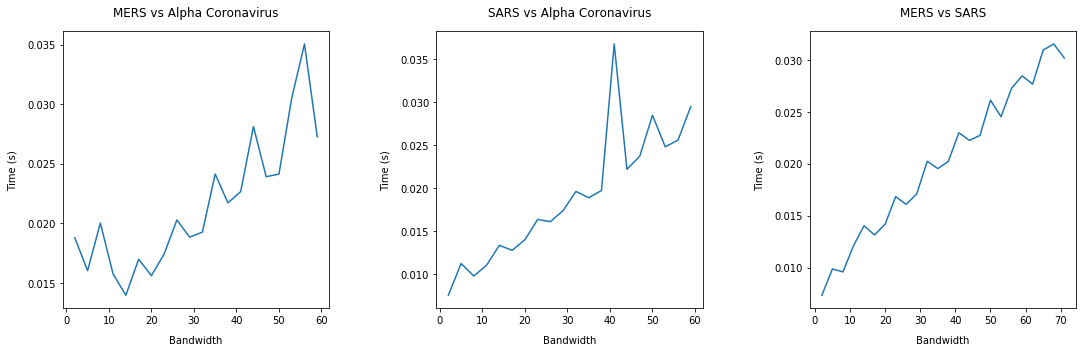

In [381]:
import matplotlib.pyplot as plt

scores, bandwidths, times = protein_comparison([mers_genomes, mers_genome_details],
                                               [alphaCOV_genomes, alphaCOV_genome_details],
                                               'M protein', 'M protein')

scores2, bandwidths2, times2 = protein_comparison([sars_genomes, sars_genome_details],
                                               [alphaCOV_genomes, alphaCOV_genome_details],
                                               'M protein', 'M protein')

scores3, bandwidths3, times3 = protein_comparison([mers_genomes, mers_genome_details],
                                               [sars_genomes, sars_genome_details],
                                               'M protein', 'M protein')


plt.subplot(1, 3, 1)
plt.plot(bandwidths, times)
plt.title('MERS vs Alpha Coronavirus', pad = 15)
plt.xlabel('Bandwidth', labelpad = 10)
plt.ylabel('Time (s)', labelpad = 10)
plt.gcf().set_size_inches(10, 5)

plt.subplot(1, 3, 2)
plt.plot(bandwidths2, times2)
plt.title('SARS vs Alpha Coronavirus', pad = 15)
plt.xlabel('Bandwidth', labelpad = 10)
plt.ylabel('Time (s)', labelpad = 10)
plt.gcf().set_size_inches(10, 5)

plt.subplot(1, 3, 3)
plt.plot(bandwidths3, times3)
plt.title('MERS vs SARS', pad = 15)
plt.xlabel('Bandwidth', labelpad = 10)
plt.ylabel('Time (s)', labelpad = 10)
plt.gcf().set_size_inches(10, 5)
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=1.5, top=None, wspace=None, hspace=None)
plt.show()

### Comparing common proteins between SARS, MERS, and Alpha Coronavirus

The following cells produce heat maps comparing 5 different proteins that the 3 different viruses have in common. To test the algorithm with other proteins, you can just add the specific protein to the 'proteins' array.

In [412]:
proteins = ['M protein', 'N protein', 'S protein', 'ORF3', 'spike glycoprotein']

def compare_proteins(virus1, virus2):
    array = np.zeros(( len(proteins), len(proteins) ))

    for i in range(len(proteins)):
        for j in range(len(proteins)):
            scores, bandwidths, times = protein_comparison([virus1[0], virus1[1]],
                                                           [virus2[0], virus2[1]],
                                                           proteins[i],proteins[j])
            array[i][j] = scores[-1][-1][-1]
    return array

In [421]:
def plot_heatmap(virus1, virus2): 
    array = compare_proteins(virus1, virus2)
    
    fig, ax = plt.subplots()
    im = ax.imshow(array, cmap='RdBu', interpolation='nearest')
    ax.figure.colorbar(im)

    ax.set_xticks(np.arange(len(proteins)))
    ax.set_yticks(np.arange(len(proteins)))
    ax.set_xticklabels(proteins)
    ax.set_yticklabels(proteins)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    for i in range(len(proteins)):
        for j in range(len(proteins)):
            text = ax.text(j, i, array[i, j],
                           ha="center", va="center", color="w")

    if virus1[0] == sars_genomes and virus2[0] == mers_genomes:
        ax.set_title("SARS vs MERS")
    elif virus1[0] == sars_genomes and virus2[0] == alphaCOV_genomes:
        ax.set_title("SARS vs Alpha Coronavirus")
    else:
        ax.set_title("MERS vs Alpha Coronavirus")
        
    fig.tight_layout()
    plt.gcf().set_size_inches(13, 10)
    plt.show()

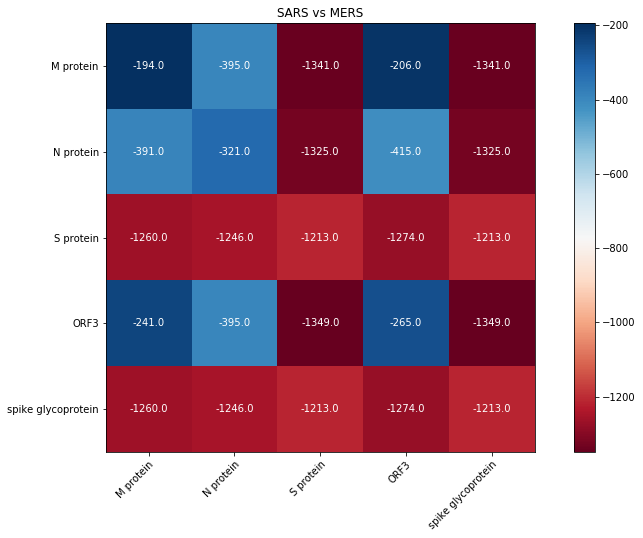

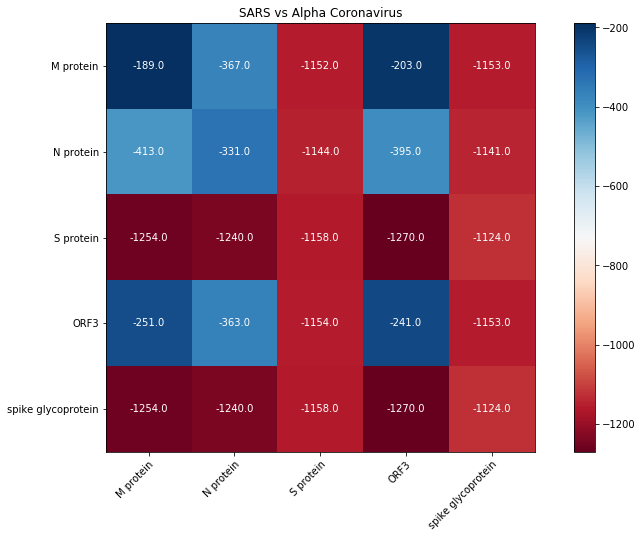

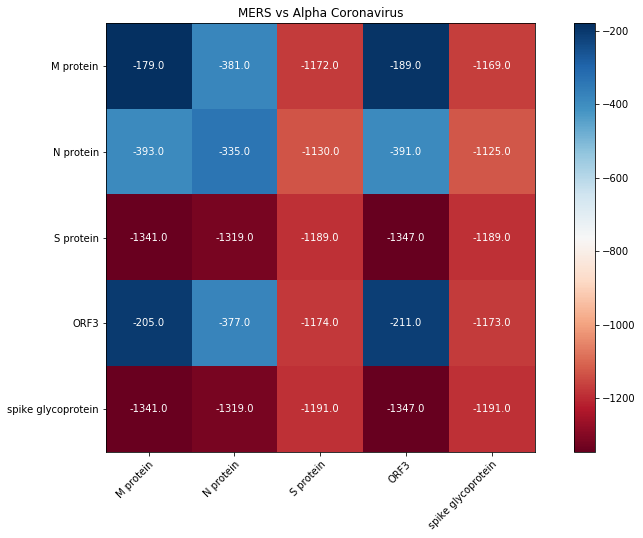

In [422]:
plot_heatmap( [sars_genomes, sars_genome_details], [mers_genomes,mers_genome_details] )
plot_heatmap( [sars_genomes, sars_genome_details], [alphaCOV_genomes,alphaCOV_genome_details] )
plot_heatmap( [mers_genomes, mers_genome_details], [alphaCOV_genomes,alphaCOV_genome_details] )